In [26]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# This generates the whole hamiltonian for the tunnelling double well

def generate_hamiltonians(a_values, b_values):
    """
    Generate and store Hamiltonians of the form:
        H = (1/2) * a * σ_z + (1/2) * b * σ_x

    Parameters
    ----------
    a_values : list or np.ndarray
        List of 'a' coefficients (energy asymmetry terms).
    b_values : list or np.ndarray
        List of 'b' coefficients (tunneling amplitude terms).

    Returns
    -------
    hamiltonians : dict
        Dictionary with keys as (a, b) tuples and values as corresponding Qobj Hamiltonians.
    """

    # Define Pauli matrices
    sigma_z = qt.sigmaz()
    sigma_x = qt.sigmax()


    hamiltonians = {}

    for a in a_values:
        for b in b_values:
            H = 0.5 * a * sigma_z + 0.5 * b * sigma_x
            hamiltonians[(a, b)] = H
    return hamiltonians


In [28]:
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)
hams = generate_hamiltonians(a_vals, b_vals)

In [29]:
H = hams[(-2.0, -1.0)]

In [30]:
H.eigenstates()

(array([-1.11803399,  1.11803399]),
 array([Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
        Qobj data =
        [[-0.97324899]
         [-0.22975292]]                                                       ,
        Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
        Qobj data =
        [[-0.22975292]
         [ 0.97324899]]                                                       ],
       dtype=object))

In [31]:
# Display eigenvals and corr eigenvec

eigenvals, eigenstates = H.eigenstates(sort='low')
for i, (E, psi) in enumerate(zip(eigenvals, eigenstates)):
    print(f"Eigenvalue {i+1}: {E:.4f}")
    print(f"Eigenstate {i+1}:")
    print(psi)
    print("-"*40)

Eigenvalue 1: -1.1180
Eigenstate 1:
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.97324899]
 [-0.22975292]]
----------------------------------------
Eigenvalue 2: 1.1180
Eigenstate 2:
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.22975292]
 [ 0.97324899]]
----------------------------------------


In [32]:
# Evolve the ground states according to Hamiltonians 

def time_evolve_ground_state(hamiltonians, state, tlist=None, save_dir="evolutions"):
    """
    Time-evolve the ground state of one Hamiltonian under all Hamiltonians in the given dictionary.

    Parameters
    ----------
    hamiltonians : dict
        Dictionary {(a, b): Qobj Hamiltonian}.
    tlist : array-like, optional
        List of time points to evolve over (default: np.linspace(0, 10, 200)).
    save_dir : str, optional
        Directory where evolved states will be stored.

    Returns
    -------
    evolutions : dict
        Dictionary {(a, b): [Qobj(t_0), Qobj(t_1), ...]} for each Hamiltonian.
    """

    if tlist is None:
        tlist = np.linspace(0, 10, 200)

    # Pick the first Hamiltonian 
    # print(list(hamiltonians.keys()))
    
    ref_key = list(hamiltonians.keys())[0]
    H_ref = hamiltonians[ref_key]
    
    
    # Find the ground states 
    # E_vals, E_states = H_ref.eigenstates(sort='low')
    psi0 = state # Ground state

    # print(f"Reference Hamiltonian: {ref_key}")
    # print(f"Ground state energy: {E_vals[0]:.4f}\n")

    # Dictionary to store results
    evolutions = {}

    for key, H in hamiltonians.items():
        result = qt.sesolve(H, psi0, tlist)
        evolutions[key] = result.states

        # Save to pickle
        # filename = f"evolution_a{key[0]:.3f}_b{key[1]:.3f}.pkl"
        # filepath = os.path.join(save_dir, filename)
        # with open(filepath, "wb") as f:
        #     pickle.dump(result, f)

        # print(f"Evolved under H(a={key[0]:.2f}, b={key[1]:.2f}) → saved to {filename}")

    return evolutions

In [33]:
# All the previous stuuff again

a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)
hams = generate_hamiltonians(a_vals, b_vals)

# Time indices
tlist = np.linspace(0, 5, 100)

# First Hamiltonian
H = hams[(-2.0, -1.0)]
H.eigenstates()
eigenvals, eigenstates = H.eigenstates(sort='low')

# Evolve the ground state
evolutions = time_evolve_ground_state(hamiltonians=hams, state=eigenstates[0], tlist=tlist)

In [ ]:
# Extract the first excited state from the reference Hamiltonian
excited_state = eigenstates[1]
key = (-2.0, -1.0) # Key for which Hamiltonian
states_t = evolutions[key]


# Fidelities from qutip lib 
fidelities = [qt.fidelity(excited_state, psi_t)**2 for psi_t in states_t]

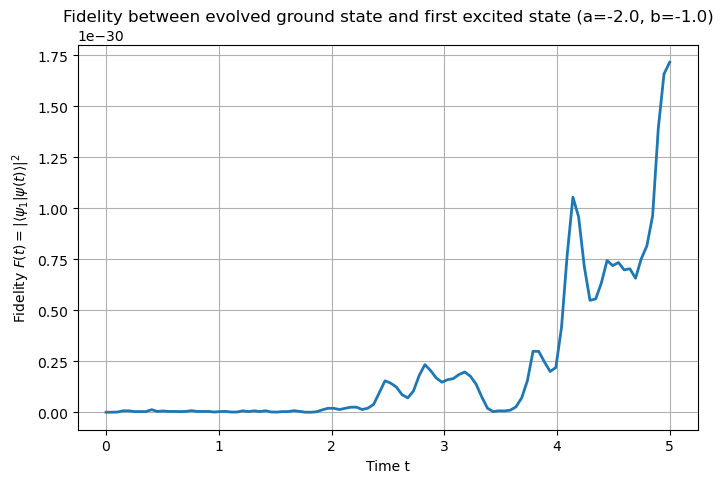

In [35]:
plt.figure(figsize=(8,5))
plt.plot(tlist, fidelities, lw=2)
plt.xlabel("Time t")
plt.ylabel(r"Fidelity $F(t) = |\langle \psi_1 | \psi(t) \rangle|^2$")
plt.title(f"Fidelity between evolved ground state and first excited state (a={key[0]}, b={key[1]})")
plt.grid(True)
plt.show()

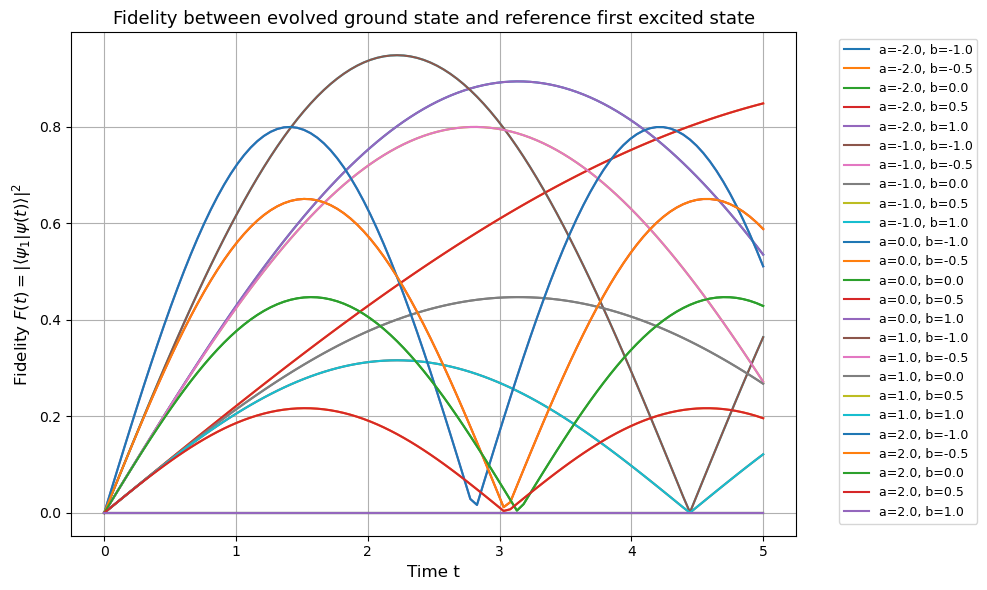

In [ ]:
plt.figure(figsize=(10, 6))

for key, states_t in evolutions.items():
    fidelities = [qt.fidelity(excited_state, psi_t) for psi_t in states_t]
    plt.plot(tlist, fidelities, label=f"a={key[0]}, b={key[1]}")

plt.xlabel("Time t", fontsize=12)
plt.ylabel(r"Fidelity $F(t) = |\langle \psi_1 | \psi(t) \rangle|^2$", fontsize=12)
plt.title("Fidelity between evolved ground state and reference first excited state", fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experimental evidence that Unitary evolution does nothing of significance to homochirality
# Only Linbladians can solve this
